In [1]:
%env OMP_NUM_THREADS=8
%env MKL_NUM_THREADS=8

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import matplotlib as mpl
from itertools import product
import scipy as sp
import scipy.interpolate

rc_cmufonts = {
    "font.family": "normal",
    "font.serif": [],
    "font.sans-serif": [],
    "font.monospace": [], 
    }
fs = 10
font = {'size'   : fs}

mpl.rc('font', **font)
mpl.rcParams.update(rc_cmufonts)
mpl.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
from IPython.kernel.zmq.pylab import backend_inline
cfg = backend_inline.InlineBackend.instance()# InlineBackendConfig.instance()
cfg.figure_format = 'svg' # 'png' to switch back

sns.set_context('paper', font_scale=1.5)
sns.set_style('white')
sns.mpl.rcParams['legend.frameon'] = 'False'
#sns.rcParams['legend.frameon'] = 'False'
palette = sns.color_palette() 
fig_format = 'pgf'

import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

env: OMP_NUM_THREADS=8
env: MKL_NUM_THREADS=8


/home/hariyuki/apd/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated since IPython 4.0.You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
import sys
sys.path.append('../src/')
sys.path.append('../classify/')

## Logistic regression

In [3]:
data_dirname = '../data/'
data_filename = 'data.npz'
#cv_filename = 'phys_cv_indices_73.npz'
cv_filename = '2phys_cv_indices_73.npz'
eps = 10.*np.spacing(1.)

df = np.load(data_dirname+data_filename)
data, labels = df['data'], df['labels']
data = np.reshape(data, [data.shape[0], -1], order='F')
tmp = np.median(data, axis=0)
ind = np.where(np.abs(tmp) > eps)[0]
data = data[:, ind]

df = np.load(data_dirname+cv_filename)
train_indices, test_indices = df['train_indices'], df['test_indices']



In [4]:
len(train_indices), data.shape

(100, (870, 632))

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

def check_lambda(
    data, labels, train_indices, test_indices, Cs, multi_class='ovr',
    save_filename=None, njobs=8
):
    num_iter = len(train_indices)
    uni_labels = np.unique(labels)
    ans = np.zeros((num_iter, len(Cs), 2))
    for k in xrange(num_iter):
        train_index = train_indices[k]
        test_index = test_indices[k]
        
        train_data = [data[train_index, :], labels[train_index]]
        valid_data = [data[test_index, :], labels[test_index]]
        
        meanX = np.median(train_data[0], axis=0, keepdims=True)
        stdX = np.std(train_data[0], axis=0, keepdims=True, ddof=1)
        train_data[0] -= meanX
        train_data[0] /= stdX
        
        valid_data[0] -= meanX
        valid_data[0] /= stdX
        
        for i, C in enumerate(Cs):
            clf = LogisticRegression(
                C=C,
                penalty='l2',
                multi_class=multi_class,
                tol=0.001,
                n_jobs=njobs,
                verbose=0,
                solver='saga'
            )
            clf.fit(train_data[0], train_data[1])

            out_train = clf.predict_proba(train_data[0])
            out_valid = clf.predict_proba(valid_data[0])

            ans[k, i, 0] += log_loss(train_data[1], out_train, labels=uni_labels)
            ans[k, i, 1] += log_loss(valid_data[1], out_valid, labels=uni_labels)

        if save_filename is not None:
            np.savez_compressed(
                save_filename, ans=ans, Cs=Cs
            )
    return ans

In [8]:
Cs = [
    100., 50., 10., 5., 1., 0.80, 0.75, 0.65, 0.6,
    0.5, 0.25, 0.1, 0.075, 0.05, 0.025, 0.01, 0.005, 0.001
] #=> 0.8

In [ ]:
save_dirname = '../result/'
save_filename = 'check_lambda_ovr_logreg'

ans = check_lambda(
    data, labels, train_indices, test_indices, Cs, multi_class='ovr',
    save_filename=save_dirname+save_filename, njobs=2
)

In [9]:
save_dirname = '../result/'
logreg_filename = 'check_lambda_ovr_logreg.npz'
df = np.load(save_dirname+logreg_filename)
ans = np.mean(df['ans'], axis=0)
ind = np.where(ans[:, 1] == ans[:, 1].min())[0]
ind = ind[np.argmin(np.array(Cs)[ind])]
Cb_ovr_logreg = Cs[ind]
print('Best logreg (ovr): C=%.3f' % (Cb_ovr_logreg))

Best logreg (ovr): C=50.000


In [ ]:
save_filename = 'check_lambda_ovo_logreg'
ans = check_lambda(
    data, labels, train_indices, test_indices, Cs, multi_class='multinomial',
    save_filename=save_dirname+save_filename, njobs=4
)

In [10]:
save_dirname = '../result/'
logreg_filename = 'check_lambda_ovo_logreg.npz'
df = np.load(save_dirname+logreg_filename)
ans = np.mean(df['ans'], axis=0)
ind = np.where(ans[:, 1] == ans[:, 1].min())[0]
ind = ind[np.argmin(np.array(Cs)[ind])]
Cb_ovo_logreg = Cs[ind]
print('Best logreg (ovo): C=%.3f' % (Cb_ovo_logreg))

Best logreg (ovo): C=50.000


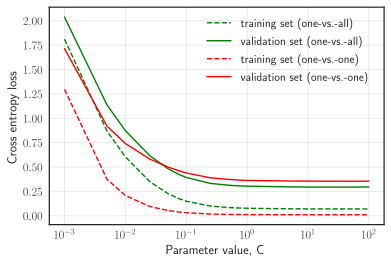

In [12]:
dirname_result = '../result/'
filename_lc_lr_ovr = 'check_lambda_ovr_logreg.npz'
filename_lc_lr_ovo = 'check_lambda_ovo_logreg.npz'

df = np.load(dirname_result+filename_lc_lr_ovr)
ans_lc_lr_ovr = np.mean(df['ans'], axis=0)

df = np.load(dirname_result+filename_lc_lr_ovo)
ans_lc_lr_ovo = np.mean(df['ans'], axis=0)

ind = np.argsort(Cs)
t = np.array(Cs)[ind]

plt.semilogx(
    t, ans_lc_lr_ovr[ind, 0], '--', color='g', label='training set (one-vs.-all)'
)
plt.semilogx(
    t, ans_lc_lr_ovr[ind, 1], '-', color='g', label='validation set (one-vs.-all)'
)
plt.semilogx(
    t, ans_lc_lr_ovo[ind, 0], '--', color='r', label='training set (one-vs.-one)'
)
plt.semilogx(
    t, ans_lc_lr_ovo[ind, 1], '-', color='r', label='validation set (one-vs.-one)'
)

plt.xlabel('Parameter value, C')
plt.ylabel('Cross entropy loss')
plt.legend(loc=1)
plt.grid(alpha=0.5)
#plt.ylim(0, .0)
plt.show()

In [13]:
ind_Cb_lr_ovr = np.argmin(ans_lc_lr_ovr[:, 1])
ind_Cb_lr_ovo = np.argmin(ans_lc_lr_ovo[:, 1])
Cb_lr_ovr = np.array(Cs)[ind_Cb_lr_ovr]
Cb_lr_ovo = np.array(Cs)[ind_Cb_lr_ovo]
print('Best parameters LR ovr: ', Cb_lr_ovr)
print('Best parameters LR ovo: ', Cb_lr_ovo)

('Best parameters LR ovr: ', 50.0)
('Best parameters LR ovo: ', 50.0)


In [99]:
def check_vb(
    data, labels, train_indices, test_indices, Cs, max_samples_per_class=10,
    spc_step=1, random_state=None, save_filename=None, multi_class='ovr', njobs=1
):
    if random_state is not None:
        np.random.seed(random_state)
    num_iter = len(train_indices)
    Nruns = max_samples_per_class // spc_step
    ans = np.zeros((num_iter, len(Cs), Nruns, 2))
    uni_labels = np.unique(labels)
    for k_iter in range(num_iter):
        train_index = np.array(train_indices[k_iter])
        test_index = test_indices[k_iter]
        
        current_train_labels = labels[train_index]
        train_labels_n = []
        for k_label in range(len(uni_labels)):
            ind = np.where(current_train_labels == uni_labels[k_label])[0]
            np.random.shuffle(ind)
            ind = ind[:max_samples_per_class]
            train_labels_n.append(train_index[ind])
        
        valid_data = [data[test_index, :], labels[test_index]]
        i_spc = 0
        for n_samples in range(spc_step, max_samples_per_class+spc_step, spc_step):
            ind_train = [x[:n_samples+1].tolist() for x in train_labels_n]
            ind_train = list(reduce(lambda x, y: x+y, ind_train, []))
            ctrain_data = [data[ind_train, :], labels[ind_train]]
            meanX = np.median(ctrain_data[0], axis=0, keepdims=True)
            stdX = np.std(ctrain_data[0], axis=0, keepdims=True, ddof=1)
            ctrain_data[0] -= meanX
            ctrain_data[0] /= stdX
        
            cvalid_data = valid_data[0] - meanX
            cvalid_data /= stdX
            for i, C in enumerate(Cs):
                clf = LogisticRegression(
                    C=C,
                    penalty='l2',
                    multi_class=multi_class,
                    tol=0.001,
                    n_jobs=njobs,
                    verbose=0,
                    solver='saga'
                )
                clf.fit(ctrain_data[0], ctrain_data[1])

                out_train = clf.predict_proba(ctrain_data[0])
                out_valid = clf.predict_proba(cvalid_data)

                ans[k_iter, i, i_spc, 0] += log_loss(
                    ctrain_data[1], out_train, labels=uni_labels
                )
                ans[k_iter, i, i_spc, 1] += log_loss(
                    valid_data[1], out_valid, labels=uni_labels
                )
            i_spc += 1
        if save_filename is not None:
            np.savez_compressed(
                save_filename, ans=ans, Cs=Cs,
                max_samples_per_class=max_samples_per_class,
                spc_step=spc_step
            )
    return ans



In [28]:
random_state = 198
save_dirname = '../result/'
save_filename = 'check_vb_ovr_logreg'
ans2 = check_vb(
    data, labels, train_indices, test_indices, Cs=[Cb_lr_ovr],
    max_samples_per_class=16, random_state=random_state,
    save_filename=save_dirname+save_filename, multi_class='ovr',
    njobs=6
)
# unnormalized in file!

In [30]:
random_state = 198
save_dirname = '../result/'
save_filename = 'check_vb_ovo_logreg'
ans2 = check_vb(
    data, labels, train_indices, test_indices, Cs=[Cb_lr_ovo],
    max_samples_per_class=16, random_state=random_state,
    save_filename=save_dirname+save_filename, multi_class='multinomial',
    njobs=6
)
# unnormalized in file!

[50.]
[50.]


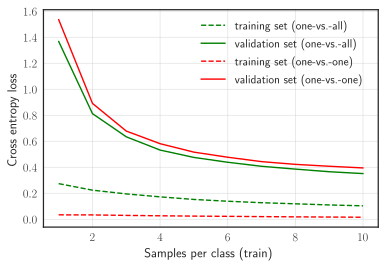

In [34]:
dirname_result = '../result/'
filename_lc_lr_ovr = 'check_vb_ovr_logreg.npz'
filename_lc_lr_ovo = 'check_vb_ovo_logreg.npz'

df = np.load(dirname_result+filename_lc_lr_ovr)
ans_lc_lr_ovr = np.mean(df['ans'], axis=0)[0] # len(Cs) = 1, Cs = [Cb]
print(df['Cs'])

df = np.load(dirname_result+filename_lc_lr_ovo)
ans_lc_lr_ovo = np.mean(df['ans'], axis=0)[0] # len(Cs) = 1, Cs = [Cb]
print(df['Cs'])

number_of_observations = 10
number_of_observations = min(
    number_of_observations,
    ans_lc_lr_ovr.shape[0],
    ans_lc_lr_ovo.shape[0]
)

t = 1+np.arange(number_of_observations)
ans_lc_lr_ovr = ans_lc_lr_ovr[:number_of_observations, :]
ans_lc_lr_ovo = ans_lc_lr_ovo[:number_of_observations, :]

plt.plot(t, ans_lc_lr_ovr[:, 0], '--', color='g', label='training set (one-vs.-all)')
plt.plot(t, ans_lc_lr_ovr[:, 1], '-', color='g', label='validation set (one-vs.-all)')
plt.plot(t, ans_lc_lr_ovo[:, 0], '--', color='r', label='training set (one-vs.-one)')
plt.plot(t, ans_lc_lr_ovo[:, 1], '-', color='r', label='validation set (one-vs.-one)')

plt.xlabel('Samples per class (train)')
plt.ylabel('Cross entropy loss')
plt.legend(loc=1)
plt.grid(alpha=0.5)
plt.show()

In [14]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def main_func(
    data, labels, train_indices, test_indices, C,
    save_filename=None, multi_class='ovr', scale='standard-median',
    average='macro', njobs=8
):
    num_iter = len(train_indices)
    uni_labels = np.unique(labels)
    num_classes = len(uni_labels)
    
    recall = np.zeros((num_iter, num_classes+1, 2))
    precision = np.zeros((num_iter, num_classes+1, 2))
    f1 = np.zeros((num_iter, num_classes+1, 2))
    accuracy = np.zeros((num_iter, 2))
    logloss = np.zeros((num_iter, 2))
    
    for k_iter in range(num_iter):
        train_index = train_indices[k_iter]
        test_index = test_indices[k_iter]
        
        
        train_data = [data[train_index, :], labels[train_index]]
        valid_data = [data[test_index , :], labels[test_index ]]
        
        if scale.startswith('standard'):
            if scale == 'standard-median':
                meanX = np.median(train_data[0], axis=0, keepdims=True)
            elif scale =='standard-mean':
                meanX = np.mean(train_data[0], axis=0, keepdims=True)
            else:
                raise ValueError
            stdX = np.std(train_data[0], axis=0, keepdims=True, ddof=1)
            train_data[0] -= meanX
            train_data[0] /= stdX

            valid_data[0] -= meanX
            valid_data[0] /= stdX
        elif scale == 'minmax':
            funsc = lambda x: (
                x - x.min(axis=1, keepdims=True)
            ) / (
                x.max(axis=1, keepdims=True) - x.min(axis=1, keepdims=True)
            )
            
            train_data[0] = funsc(train_data[0])
            valid_data[0] = funsc(valid_data[0])
        
        clf = LogisticRegression(
            C=C,
            penalty='l2',
            multi_class=multi_class,
            tol=0.001,
            n_jobs=njobs,
            verbose=0,
            solver='saga'
        )
        clf.fit(train_data[0], train_data[1])

        
        out_train = clf.predict_proba(train_data[0])
        out_valid = clf.predict_proba(valid_data[0])

        logloss[k_iter, 0] = log_loss(train_data[1], out_train, labels=uni_labels)
        logloss[k_iter, 1] = log_loss(valid_data[1], out_valid, labels=uni_labels)

        out_train = clf.predict(train_data[0])
        out_valid = clf.predict(valid_data[0])

        accuracy[k_iter, 0] = accuracy_score(train_data[1], out_train)
        accuracy[k_iter, 1] = accuracy_score(valid_data[1], out_valid)
        precision[k_iter, :-1, 0] = precision_score(
            train_data[1], out_train, average=None, labels=uni_labels
        )
        precision[k_iter, -1, 0] = precision_score(
            train_data[1], out_train, average=average, labels=uni_labels
        )
        precision[k_iter, :-1, 1] = precision_score(
            valid_data[1], out_valid, average=None, labels=uni_labels
        )
        precision[k_iter, -1, 1] = precision_score(
            valid_data[1], out_valid, average=average, labels=uni_labels
        )

        recall[k_iter, :-1, 0] = recall_score(
            train_data[1], out_train, average=None, labels=uni_labels
        )
        recall[k_iter, -1, 0] = recall_score(
            train_data[1], out_train, average=average, labels=uni_labels
        )
        recall[k_iter, :-1, 1] = recall_score(
            valid_data[1], out_valid, average=None, labels=uni_labels
        )
        recall[k_iter, -1, 1] = recall_score(
            valid_data[1], out_valid, average=average, labels=uni_labels
        )

        f1[k_iter, :-1, 0] = f1_score(
            train_data[1], out_train, average=None, labels=uni_labels
        )
        f1[k_iter, -1, 0] = f1_score(
            train_data[1], out_train, average=average, labels=uni_labels
        )
        f1[k_iter, :-1, 1] = f1_score(
            valid_data[1], out_valid, average=None, labels=uni_labels
        )
        f1[k_iter, -1, 1] = f1_score(
            valid_data[1], out_valid, average=average, labels=uni_labels
        )

        np.savez_compressed(
            save_filename, accuracy=accuracy, recall=recall, f1=f1,
            precision=precision, C=C, logloss=logloss
        )
    return accuracy, precision, recall, f1, logloss


In [17]:
save_dirname = '../result/'
save_filename = 'tuned_logreg_ovr'

rv1 = main_func(
    data, labels, train_indices, test_indices, C=Cb_ovr_logreg,
    save_filename=save_dirname+save_filename, multi_class='ovr',
    average='macro'
)

In [46]:
data_dirname = '../data/'
cv_filename2 = 'phys_cv_indices_732.npz'
eps = 10.*np.spacing(1.)

df = np.load(data_dirname+cv_filename2)
train_indices2, test_indices2 = df['train_indices'], df['test_indices']



In [47]:
save_dirname = '../result/'
save_filename = 'tuned_logreg_ovr2'

rv2 = main_func(
    data, labels, train_indices2, test_indices2, C=Cb_ovr_logreg,
    save_filename=save_dirname+save_filename, multi_class='ovr',
    average='macro'
)

In [18]:
import pandas as pd

save_dirname = '../result/'
filenames = [
    'tuned_logreg_ovr.npz'
]

cum_df = {
    'accuracy (train)': [],
    'accuracy (valid)': [],
    'recall (train)': [],
    'recall (valid)': [],
    'precision (train)': [],
    'precision (valid)': [],
    'f1 (train)': [],
    'f1 (valid)': []
}

cum_df2 = {
    'accuracy (train)': [],
    'accuracy (valid)': [],
    'recall (train)': [],
    'recall (valid)': [],
    'precision (train)': [],
    'precision (valid)': [],
    'f1 (train)': [],
    'f1 (valid)': []
}

for filename in filenames:
    df = np.load(save_dirname+filename)
    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        tmp = np.mean(df[metric], axis=0)
        if tmp.ndim > 1:
            tmp = tmp[-1, :]
        cum_df['%s (train)' % (metric)].append(tmp[0])
        cum_df['%s (valid)' % (metric)].append(tmp[1])
    '''
    df = np.load(save_dirname+filename.replace('.npz', '2.npz'))
    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        tmp = np.mean(df[metric], axis=0)
        if tmp.ndim > 1:
            tmp = tmp[-1, :]
        cum_df2['%s (train)' % (metric)].append(tmp[0])
        cum_df2['%s (valid)' % (metric)].append(tmp[1])
    '''
cum_df = pd.DataFrame(cum_df)
cum_df['alg'] = ['Logreg']
#cum_df2 = pd.DataFrame(cum_df2)
#cum_df2['alg'] = ['SVM (linear)', 'SVM (RBF)']

In [45]:
cum_df

,accuracy (train),accuracy (valid),f1 (train),f1 (valid),precision (train),precision (valid),recall (train),recall (valid),alg
0,1.0,0.947719,1.0,0.934519,1.0,0.937106,1.0,0.945602,Logreg


In [19]:
cum_df

,accuracy (train),accuracy (valid),f1 (train),f1 (valid),precision (train),precision (valid),recall (train),recall (valid),alg
0,1.0,0.949123,1.0,0.935759,1.0,0.938241,1.0,0.946667,Logreg


In [57]:
def pertrubate_data(
    data, n_dup, magnitude_change_limit=0.3, peaks_change_frac_range=(0.15, 0.3),
    random_state=None
):
    N, Nfeatures = data.shape
    result = np.empty([N*n_dup, Nfeatures])
    number_of_peaks = np.count_nonzero(data, axis=1)
    
    if random_state is not None:
        np.random.seed(random_state)
    for k_dup in range(n_dup):
        result[k_dup*N:(k_dup+1)*N, :] = data
        current_damaged_counts = number_of_peaks * np.random.uniform(
            peaks_change_frac_range[0],
            peaks_change_frac_range[1],
            size=(N, )
        )
        current_damaged_counts = np.trunc(current_damaged_counts)
        for k_sample in range(N):
            limiter = int(current_damaged_counts[k_sample])
            indices = np.where(data[k_sample] > 0)[0]
            np.random.permutation(indices)
            indices = indices[:limiter]
            result[k_sample+k_dup*N, indices] *= np.random.uniform(
                -magnitude_change_limit,
                magnitude_change_limit,
                size=limiter
            )
    return result
    



In [89]:
import copy

n_dup = 59
random_state = 198

artificially_damaged_data = pertrubate_data(
    data, n_dup, magnitude_change_limit=0.3, peaks_change_frac_range=(0.15, 0.3),
    random_state=random_state
)

In [97]:
merged_data = np.vstack([data, artificially_damaged_data])
merged_labels = np.array(labels.tolist()*(n_dup+1))

merged_train_indices = []
for k in range(len(train_indices)):
    k_train_indices = copy.deepcopy(train_indices[k])
    merged_train_indices.append([])
    for i in range(n_dup+1):
        merged_train_indices[-1] += (n_dup*len(labels)+np.array(k_train_indices)).tolist()

In [ ]:
random_state = 198
save_dirname = '../result/'
save_filename = 'artificial_duplicate_check_vb_ovr_logreg'
ans2 = check_vb(
    merged_data, merged_labels, merged_train_indices, test_indices, Cs=[Cb_lr_ovr],
    max_samples_per_class=300, spc_step=10, random_state=random_state,
    save_filename=save_dirname+save_filename, multi_class='ovr',
    njobs=6
)
# unnormalized in file!

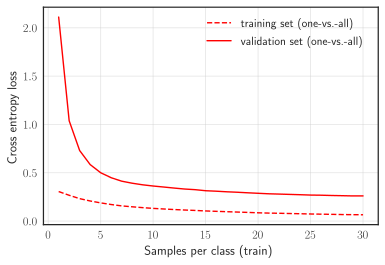

In [79]:
dirname_result = '../result/'
filename_lc_art_lr_ovr = 'artificial_duplicate_check_vb_ovr_logreg.npz'

df = np.load(dirname_result+filename_lc_art_lr_ovr)
ans_lc_art_lr_ovr = np.mean(df['ans'], axis=0)[0] # len(Cs) = 1, Cs = [Cb]

number_of_observations = 30
number_of_observations = min(
    number_of_observations,
    ans_lc_art_lr_ovr.shape[0],
)

t = 1+np.arange(number_of_observations)
ans_lc_art_lr_ovr = ans_lc_art_lr_ovr[:number_of_observations, :]

plt.plot(t, ans_lc_art_lr_ovr[:, 0], '--', color='r', label='training set (one-vs.-all)')
plt.plot(t, ans_lc_art_lr_ovr[:, 1], '-', color='r', label='validation set (one-vs.-all)')

plt.xlabel('Samples per class (train)')
plt.ylabel('Cross entropy loss')
plt.legend(loc=1)
plt.grid(alpha=0.5)
plt.show()

(12, 2)